```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for all required parts of a realistic simulation

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [25]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc


#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [26]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation, ParticleInfo
from SWESimulators import DataAssimilationUtils as dautils

from demos.realisticSimulations import norkyst_plotting


In [27]:
%cuda_context_handler gpu_ctx

# Read observation file and plot some results

In [28]:
from SWESimulators import SimReader
observation_file = "2019-11-18/complete_coast/observation_12_43_08.pickle"
truth_reader = SimReader.SimNetCDFReader("2019-11-18/complete_coast/complete_coast_original.nc")

eta = truth_reader.getLastTimeStep()[0]

obs = Observation.Observation(observation_type=dautils.ObservationType.StaticBuoys,
                              domain_size_x=truth_reader.get("nx")*truth_reader.get("dx"), domain_size_y=truth_reader.get("ny")*truth_reader.get("dy"),
                              nx=truth_reader.get("nx"), ny=truth_reader.get("ny"),
                              land_mask=eta.mask)
obs.read_pickle(observation_file)

In [29]:
filenames = os.listdir("particle_info_mpi")

particle_infos = [None] * len(filenames)
for i in range(len(particle_infos)):
    particle_infos[i] = ParticleInfo.ParticleInfo()
    particle_infos[i].read_pickle(os.path.join("particle_info_mpi",filenames[i]))

(277,)
<class 'numpy.ndarray'> (277,)


Text(0.5, 1.0, '')

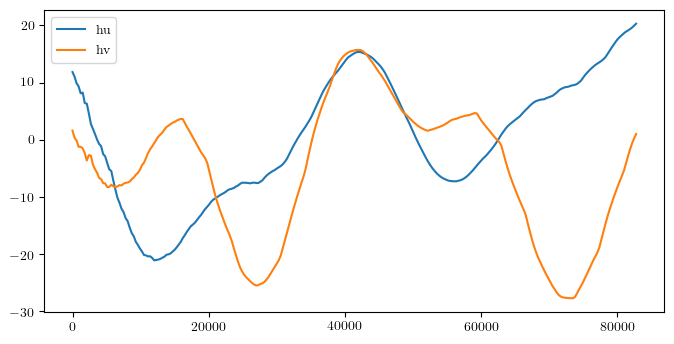

In [30]:
buoy_id = 0

def get_time_series_for_buoy(observation, buoy_id):
    
    time  = observation.obs_df[observation.time_key].to_numpy()
    hu = np.empty_like(time)
    hv = np.empty_like(time)
    
    all_buoy_obs = observation.obs_df[observation.buoy_observations_key]
    for t in range(len(time)):
        hu[t] = all_buoy_obs[t][buoy_id,0]
        hv[t] = all_buoy_obs[t][buoy_id,1]

    return time, hu, hv

t, hu, hv = get_time_series_for_buoy(obs, buoy_id)

print(t.shape)
print(type(hu), hu.shape)

fig = plt.figure(figsize=(8,4))
plt.plot(t, hu, label='hu')
plt.plot(t, hv, label='hv')
plt.legend()
plt.title('')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(60,)
<class 'numpy.ndarray'> (60,)


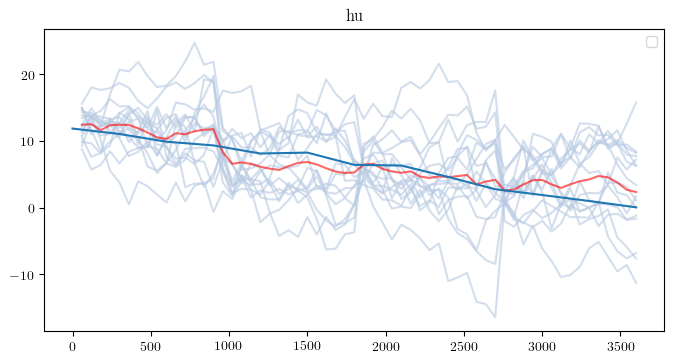

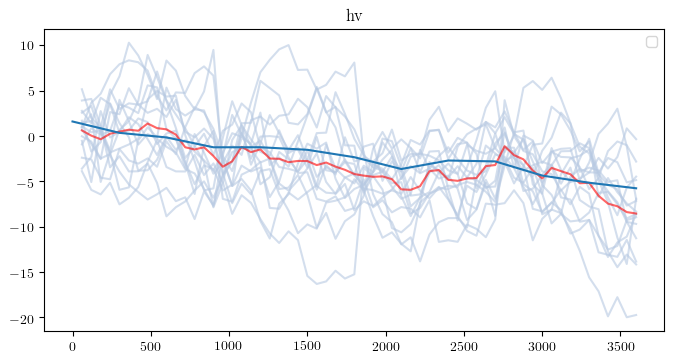

In [37]:
buoy_id = 0

def get_time_series_for_particle(particle_info, buoy_id):
    
    time  = particle_info.get_sample_times()
    hu = np.empty_like(time)
    hv = np.empty_like(time)
    
    all_buoy_obs = particle_info.state_df["state_under_drifter"]
    for t in range(len(time)):
        hu[t] = all_buoy_obs[t][buoy_id,1]
        hv[t] = all_buoy_obs[t][buoy_id,2]

    return time, hu, hv

obs_t, obs_hu, obs_hv = get_time_series_for_buoy(obs, buoy_id)

fig = plt.figure(figsize=(8,4))
plt.legend()
plt.title('')

t, _, _ = get_time_series_for_particle(particle_infos[0], buoy_id)
hu_mean = np.zeros_like(t)
for particle_info in particle_infos:
    t, hu, _ = get_time_series_for_particle(particle_info, buoy_id)
    hu_mean += hu
    plt.plot(t, hu, color='xkcd:light blue grey', alpha=0.6)

hu_mean = hu_mean/len(particle_infos)
plt.plot(t, hu_mean, color="red", alpha=0.6)
plt.plot(obs_t[:13], obs_hu[:13])
plt.title("hu")

fig = plt.figure(figsize=(8,4))
plt.legend()
plt.title('')
    
hv_mean = np.zeros_like(t)
for particle_info in particle_infos:
    t, _, hv = get_time_series_for_particle(particle_info, buoy_id)
    hv_mean += hv
    plt.plot(t, hv, color='xkcd:light blue grey', alpha=0.6)

    
hv_mean = hv_mean/len(particle_infos)
plt.plot(t, hv_mean, color="red", alpha=0.6)
plt.plot(obs_t[:13], obs_hv[:13])
plt.title("hv")

print(t.shape)
print(type(hu), hu.shape)

